 # Neural ODE framework for generalising the Lotka-Volterra systems
## Summary
 - Comapare this with: https://gist.github.com/ChrisRackauckas/a531030dc7ea5c96179c0f5f25de9979

In [1]:
import jax

print("\n############# Lotka-Volterra with Neural ODE #############\n")
print("Available devices:", jax.devices())

from jax import config
##  Debug nans
# config.update("jax_debug_nans", True)

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx

import matplotlib.pyplot as plt

from functools import partial
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

from nodax._utils import *


############# Lotka-Volterra with Neural ODE #############

Available devices: [cuda(id=0)]

############# Inductive Bias Learning for Dynamical Systems #############

Jax version: 0.4.19
Available devices: [cuda(id=0)]


In [2]:
# SEED = 27
SEED = np.random.randint(0, 1000)

## Integrator hps
# integrator = rk4_integrator
# integrator = dopri_integrator

## Optimiser hps
init_lr = 1e-3

## Training hps
print_every = 100
nb_epochs = 5000
# batch_size = 128*10
batch_size = 1

In [3]:
## Load data from 

In [4]:
data_load_folder = "runs/30012024-165151/"
run_folder = data_load_folder + "oneforall/"
if not os.path.exists(run_folder):
    os.makedirs(run_folder)

In [5]:
raw_data = np.load(data_load_folder+"train_data.npz")
data, t_eval = raw_data['X'], raw_data['t']

data = jnp.reshape(data, (-1, data.shape[2], data.shape[3]))
print("data shape:", data.shape)

data shape: (100, 100, 2)


In [6]:
# from equinox.internal import error_if

# from graphpint.integrators import *
## Set the environment variable EQX_ON_ERROR=breakpoint
# import os
# os.environ["EQX_ON_ERROR"] = "breakpoint"

# jax.devices("cpu")

In [7]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    params: jnp.ndarray

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

        self.params = jnp.abs(jax.random.normal(key, (4,)))

    def __call__(self, t, y, args):
        ret = self.mlp(y)
        return ret

In [8]:
def rk4_integrator(rhs, y0, t, rtol, atol, hmax, mxstep, max_steps_rev, kind):
  def step(state, t):
    y_prev, t_prev = state
    h = t - t_prev
    args = None
    k1 = h * rhs(t_prev, y_prev, args)
    k2 = h * rhs(t_prev + h/2., y_prev + k1/2., args)
    k3 = h * rhs(t_prev + h/2., y_prev + k2/2., args)
    k4 = h * rhs(t + h, y_prev + k3, args)
    y = y_prev + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return (y, t), y
  _, ys = jax.lax.scan(step, (y0, t[0]), t[1:])
  return jnp.concatenate([y0[jnp.newaxis, :], ys], axis=0)

class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        ys_hat = rk4_integrator(self.func, y0, ts, None, None, None, None, None, None)
        return ys_hat, ts.shape[0]
    
        # solution = diffrax.diffeqsolve(
        #     diffrax.ODETerm(self.func),
        #     diffrax.Tsit5(),
        #     t0=ts[0],
        #     t1=ts[-1],
        #     dt0=ts[1] - ts[0],
        #     y0=y0,
        #     stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
        #     saveat=diffrax.SaveAt(ts=ts),
        #     max_steps=4096*1,    ## 4096//200 for debugging
        # )

        # # jax.debug.print("Solution: {}", solution.stats)
        # nfes = solution.stats["num_steps"]      ## Actually, the number of steps of taken

        # return solution.ys, nfes

In [9]:
def get_data(dataset_size, *, key):
    ts = t_eval
    ys = data
    return ts, ys

In [10]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

Step:     0,    Loss: 1.93700635,    NFEs:   900,    CPTime: 1.2347
Step:  1000,    Loss: 1.66811287,    NFEs:   900,    CPTime: 0.0081
Step:  2000,    Loss: 1.21382785,    NFEs:   900,    CPTime: 0.0080
Step:  3000,    Loss: 0.79592276,    NFEs:   900,    CPTime: 0.0080
Step:  4000,    Loss: 0.86479962,    NFEs:   900,    CPTime: 0.0080
Step:  4999,    Loss: 0.61240631,    NFEs:   900,    CPTime: 0.0084
Step:     0,    Loss: 1.13113737,    NFEs:  3600,    CPTime: 0.9801
Step:  1000,    Loss: 1.38302219,    NFEs:  3600,    CPTime: 0.0356
Step:  2000,    Loss: 1.17539907,    NFEs:  3600,    CPTime: 0.0413
Step:  3000,    Loss: 1.19134617,    NFEs:  3600,    CPTime: 0.0354
Step:  4000,    Loss: 1.29566133,    NFEs:  3600,    CPTime: 0.0357
Step:  5000,    Loss: 1.00634158,    NFEs:  3600,    CPTime: 0.0352
Step:  6000,    Loss: 1.03897393,    NFEs:  3600,    CPTime: 0.0354
Step:  7000,    Loss: 1.15550482,    NFEs:  3600,    CPTime: 0.0346
Step:  8000,    Loss: 1.15934420,    NFEs:  3600

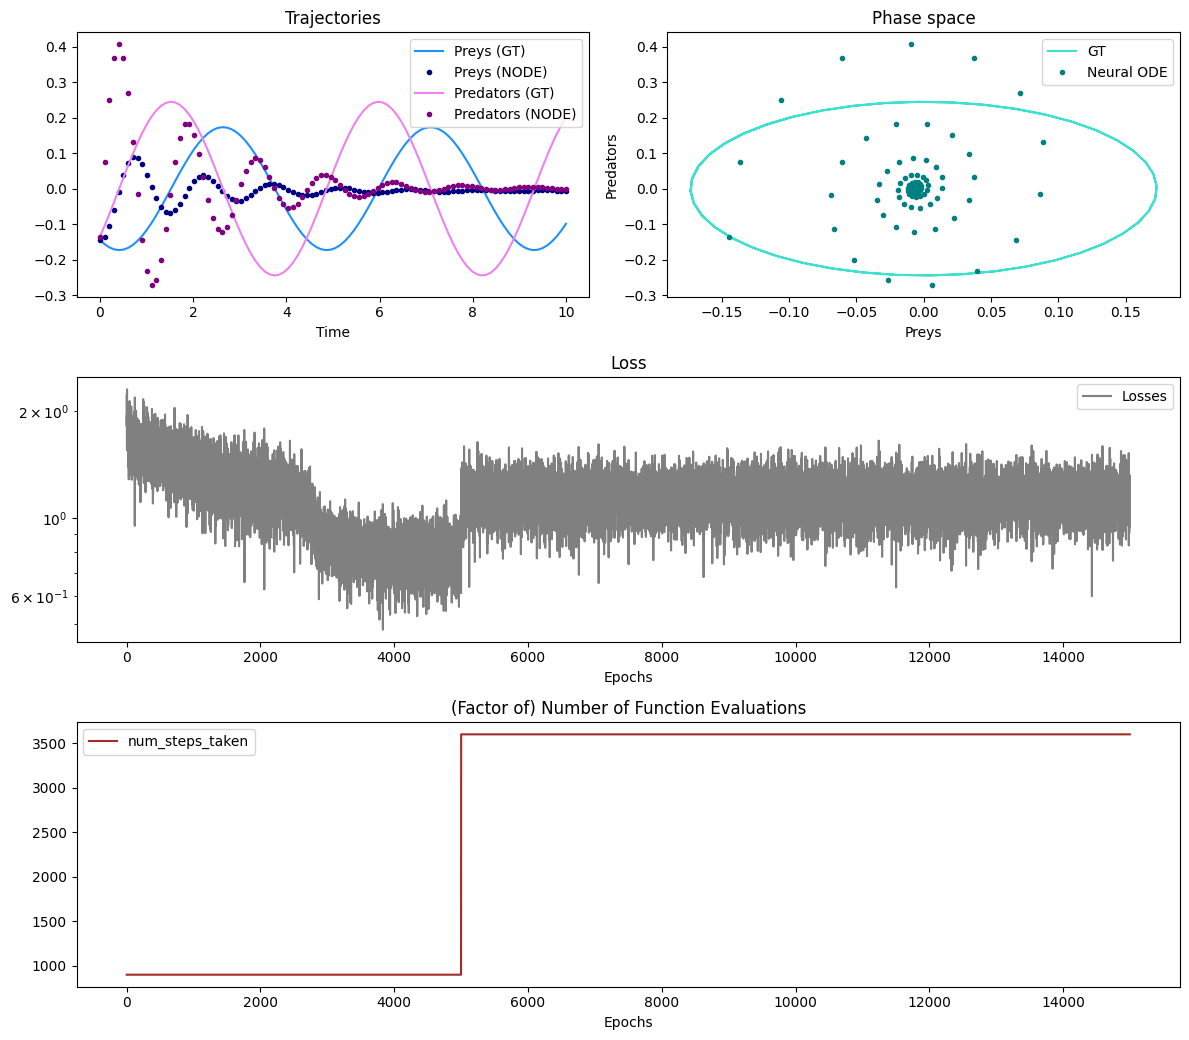

In [11]:
def main(
    dataset_size=None,
    batch_size=9*4,
    lr_strategy=(3e-5, 3e-6),
    length_strategy=(0.25, 1.0),   ## If you increase the length, you must decrease the learning rate. Relation is non-linear
    steps_strategy=(5000, 10000),
    width_size=64*1,
    depth=3,
    seed=1081,
    plot=True,
    print_every=1000,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    ## Save ts and ys in npz file
    # jnp.savez("data/lotka_voltera_diffrax.npz", ts=ts, ys=ys)
    # exit()

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.
    # Another thing is that the small number of time steps avoids the blowup we tipically 
    # face with stiff problems.

    def params_norm(params):
        """ norm of the parameters`"""
        return jnp.array([jnp.linalg.norm(x) for x in jax.tree_util.tree_leaves(params)]).sum()

    @partial(eqx.filter_value_and_grad, has_aux=True)
    def grad_loss(model, ti, yi):
        y_pred, nfes = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        # return jnp.mean((yi - y_pred) ** 2)

        ## TODO APHYNITY-style loss: https://arxiv.org/abs/2010.04456
        # return jnp.mean((yi - y_pred) ** 2) + 1e-3*params_norm(model.func.mlp.layers), (jnp.sum(nfes))
        return jnp.mean((yi - y_pred) ** 2), jnp.sum(nfes)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        (loss, nfes), grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state, nfes

    losses = []
    nfes = []
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state, nfe_step = make_step(_ts, yi, model, opt_state)
            end = time.time()
            losses.append(loss)
            nfes.append(nfe_step)
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step:-5d},    Loss: {loss:-.8f},    NFEs: {nfe_step:-5d},    CPTime: {end - start:-.4f}")

    ## Save the model with eqx.tree_serialise
    eqx.tree_serialise_leaves(run_folder+"model.pkl", model)

    ## Save the loss
    np.save(run_folder+"loss.npy", np.array(losses))


    if plot:
        plot_result(0, model, losses, nfes, ts, ys)

    return ts, ys, model


def plot_result(traj, model, losses, nfes, ts, ys):
    # fig, ax = plt.subplots(2, 2, figsize=(6*2, 3.5*2))
    fig, ax = plt.subplot_mosaic('AB;CC;DD', figsize=(6*2, 3.5*3))
    model_y, _ = model(ts, ys[traj, 0])   ## TODO predicting on the entire trajectory ==forecasting !

    ax['A'].plot(ts, ys[traj, :, 0], c="dodgerblue", label="Preys (GT)")
    ax['A'].plot(ts, model_y[:, 0], ".", c="navy", label="Preys (NODE)")

    ax['A'].plot(ts, ys[traj, :, 1], c="violet", label="Predators (GT)")
    ax['A'].plot(ts, model_y[:, 1], ".", c="purple", label="Predators (NODE)")
    
    ax['A'].set_xlabel("Time")
    ax['A'].set_title("Trajectories")
    ax['A'].legend()

    ax['B'].plot(ys[traj, :, 0], ys[traj, :, 1], c="turquoise", label="GT")
    ax['B'].plot(model_y[:, 0], model_y[:, 1], ".", c="teal", label="Neural ODE")
    ax['B'].set_xlabel("Preys")
    ax['B'].set_ylabel("Predators")
    ax['B'].set_title("Phase space")
    ax['B'].legend()

    ax['C'].plot(losses, c="grey", label="Losses")
    ax['C'].set_xlabel("Epochs")
    ax['C'].set_title("Loss")
    ax['C'].set_yscale('log')
    ax['C'].legend()

    ax['D'].plot(nfes, c="brown", label="num_steps_taken")
    ax['D'].set_xlabel("Epochs")
    ax['D'].set_title("(Factor of) Number of Function Evaluations")
    ax['D'].legend()

    plt.tight_layout()
    plt.savefig(run_folder+"neural_ode_diffrax.png")
    plt.show()



def test_mse_model(model, ts, ys):
    y_pred, nfes = jax.vmap(model, in_axes=(None, 0))(ts, ys[:, 0, :])
    return jnp.mean((ys[:, :, :] - y_pred) ** 2)
















# with jax.profiler.trace("/data/jax-trace", create_perfetto_link=False):
ts, ys, model = main()

In [12]:
## Load the model with eqx.tree_deserialise
skeleton = NeuralODE(2, 64, 3, key=jrandom.PRNGKey(0))
model = eqx.tree_deserialise_leaves(run_folder+"model.pkl", skeleton)

test_mse_model(model, ts, ys)

Array(1.1447523, dtype=float32)